In [1]:
# new imports 
import os
import pandas as pd
import numpy as np
import IPython.display as ipd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

# imports from prev proj
import sys
import librosa
import librosa.display
from pathlib import Path
import csv
import warnings  # record warnings from librosa
from tqdm import tqdm
from audioread import NoBackendError
import datetime
import pickle as pkl
from pathlib import Path

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from pickle import dump
from pickle import load
from sklearn.metrics import accuracy_score

from pydub.utils import make_chunks
from pydub import AudioSegment



from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dropout, MaxPooling2D, Activation,Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model

    
    
from shutil import copyfile



Using TensorFlow backend.


In [2]:
#  global objects
# todo add private/public inside class
class global_For_Clf():
    def __init__(self, clf_label):
        #  changed for every class (for example: scream, cry, ...)
        self.clf_label = clf_label  # have to create a clf with a label

        # keeping the hardcoded 20 mfcc below until end of project submission, later update it to generic mfcc amount
        self.data_file_path = 'csv/'+str(self.get_clf_label())+'/data_'+str(self.get_clf_label())+'_mfcc_20.csv'
        self.csv_to_pkl_path = 'pickle/'+str(self.get_clf_label())+'/combined_lower_amount.pkl' # relevant to modular file TODO currently this is only for scream
        self.path_csv_train_test_data = 'csv/'+str(self.get_clf_label())+'/train_test_data.csv'  # chosen 1:1 ratio data, selected from data.csv
        self.resultsPath = 'results/'+str(self.get_clf_label())+'/experiments_results.csv'

        # end of class changes

        self.n_mfcc = 20  # lev's initial value here was 40- this is the feature resolution- usually between 12-40
        self.k_folds = 5  # amount of folds in k-fold
        # inside create_csv() more columns will be added to the csv head
        # TODO lev-future_improvement edit/add to get better results
        self.csv_initial_head = 'filename spectral_centroid zero_crossings spectral_rolloff chroma_stft rms mel_spec'

        self.min_wav_duration = 0.5  # wont use shorter wav files

        self.nearMissRatio = 2  # 2 means <positives amount>/2
        #                           which means were taking 50% from nearMiss_<clf label> for negatives

        self.nearMiss_samples = -1  # -1 is initial invalid value which will be changed on relevant functions
        self.nearMissLabel = "NearMiss_" + str(self.clf_label)

        self.Kfold_testSize = 0.2

        self.sampling_data_repetitions = 5  # sampling randomly the data to create 1:1 ratio
        self.k_fold_repetitions: int = 5  # doing repeated k-fold for better evaluation

        self.positives = -1  # -1 represents invalid value as initial value
        self.negatives = -1

        self.try_lower_amount = np.inf

        self.model = None  # here a model will be saved- the saved model shouldn't be trained
        self.finalModelsPath = 'models/final_models'
        self.isTrained = False

        self.userInput = ''
        
        self.split_by_sec = 3  # split every X seconds
        self.tested_file_name = ''  # name of file for prediction
        self.predictor_pos_percent_condition = 0  # above 0.XX will consider as positive prediction 0 means dont use this


    def getInputDim(self):
        amount = len(self.csv_initial_head.split()) + self.n_mfcc - 1  # -1 because filename isnt a feature
        return amount

    def get_total_samples(self):
        return self.positives + self.negatives

    def get_model_name(self):
        model_name = (type(self.model)).__name__
        return model_name

    def get_clf_label(self):
            return self.clf_label


#  exceptions
class NotEnoughPositiveSamples(Exception):
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return repr(self.value)


In [3]:
def extract_feature_to_csv(wav_path, label, data_file_path, min_wav_duration, fcc_amount):
    """

    :return: writes one row to wav_path with extracted features

    """
    # extract features for a wav file
    wav_name = wav_path.name  # 110142__ryding__scary-scream-4.wav
    wav_name = wav_name.replace(" ", "_")  # lev bug fix to align csv columns

    """
    # lev upgrading error tracking- know which file caused the error
    try:
    """
    wav_data, sampling_rate = librosa.load(wav_path, duration=5, sr=22050)

    wav_duration = librosa.get_duration(y=wav_data, sr=sampling_rate)

    # lev- dont use really short audio
    if (wav_duration < min_wav_duration):
        print("skipping " + wav_name + " ,duration= " + str(wav_duration))
        return

    with warnings.catch_warnings(record=True) as feature_warnings:
        #  spectral_centroid
        feature_wav_spec_cent = librosa.feature.spectral_centroid(y=wav_data, sr=sampling_rate)
        #  print(feature_wav_spec_cent.shape)  #  (1, 216)

        #  zero crossings
        zcr = librosa.feature.zero_crossing_rate(wav_data)
        #  print("sum "+ str(np.sum(zcr)))

        #  spectral_rolloff
        rolloff = librosa.feature.spectral_rolloff(y=wav_data, sr=sampling_rate)
        # print(rolloff.shape)
        # print(rolloff[0][0:3])

        #  chroma_stft
        chroma_stft = librosa.feature.chroma_stft(y=wav_data, sr=sampling_rate)
        #  print(chroma_stft.shape)

        #  rms and mfccs
        n_mfcc = fcc_amount  # resolution amount
        mfccs = librosa.feature.mfcc(y=wav_data, sr=sampling_rate, n_mfcc=n_mfcc)
        S, phase = librosa.magphase(mfccs)
        rms = librosa.feature.rms(S=S)
        #  print(rms.shape)

        # mel spectogram
        mel_spec = librosa.feature.melspectrogram(y=wav_data, sr=sampling_rate)

        # mfccs
        #  print(mfccs.shape)
        # if there ara warnings- print and continue- for example Warning: Trying to estimate tuning from empty frequency set
        # this is an OK warning- it just means that its really quiet..as in street ambient during the evenning..its a
        # good negative example.
        if len(feature_warnings) > 0:
            for feature_warning in feature_warnings:
                print("Warning: {} Triggered in:\n {}\nwith a duration of {} seconds.\n".format(
                    feature_warning.message, wav_path, wav_duration))

        # got here - no warnings for this wav_path
        # normalize what isnt normalized
        to_append = f'{wav_name} {np.mean(feature_wav_spec_cent)} {np.mean(zcr)} {np.mean(rolloff)} {np.mean(chroma_stft)}' \
                    f' {np.mean(rms)} {np.mean(mel_spec)}'
        for e in mfccs:
            to_append += f' {np.mean(e)}'

        to_append += f' {label}'

        #  save to csv (append new lines)
        file = open(data_file_path, 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

        #  print(to_append)


def create_csv(data_file_path, min_wav_duration, n_mfcc_number, header, fcc_amount,source="train"):
    """
    input: uses screamGlobals for input
    output: .csv file with screamGlobals.csv_initial_head columns
    """
    # important variables
    # data_file_path = clfGlobals.data_file_path
    # min_wav_duration = clfGlobals.min_wav_duration
    #  print(data_file_path, min_wav_duration)
    """
    #  prevent data file over run by accident
    if os.path.exists(data_file_path):
        text = input(f'Press the space bar to override {data_file_path} and continue with the script')
        if text != ' ':
            sys.exit('User aborted script, data file saved :)')
    """
    # logic modification- just verify corectness if file exists- never override.
    if os.path.exists(data_file_path):
        # verify table fits the mfcc number- if True- return (continue with script as usuall), else- raise Error
        # n_mfcc_number = clfGlobals.n_mfcc
        with open(data_file_path) as csvFile:
            reader = csv.reader(csvFile)
            field_names_list = next(reader)  # read first row only (header)
            mfcc_list = [x for x in field_names_list if x.startswith("mfcc")]
            len_actual_mfcc_features = len(mfcc_list)
        if len_actual_mfcc_features == n_mfcc_number:
            print(f'OK: {len_actual_mfcc_features} ==  n_mfcc_number={n_mfcc_number}')
            return
        else:
            raise Exception(f'len_actual_mfcc_features'
                            f'(mfcc inside {data_file_path}={len_actual_mfcc_features},'
                            f' but n_mfcc_number(inside globals class of this script)={n_mfcc_number},'
                            f' values must be equal.')

    # create header for csv
    # header = clfGlobals.csv_initial_head
    # fcc_amount = clfGlobals.n_mfcc
    for i in range(1, fcc_amount + 1):
        header += f' mfcc_{i}'
    header += ' label'
    header = header.split()  # split by spaces as default

    file = open(data_file_path, 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)

    # load features from each wav file- put inside the lines below as a function

    # reaching each wav file
    path_train = Path(source)
    for path_label in sorted(path_train.iterdir()):
        print("currently in : " + str(path_label))  # train\negative
        positiveOrNegative = path_label.name  # negative
        #  print(label)
        for path_class in tqdm(sorted(path_label.iterdir())):
            # print info
            print("currently in class: " + str(path_class))
            # print amount of files in directory
            onlyfiles = next(os.walk(path_class))[2]  # dir is your directory path as string
            wav_amount: int = len(onlyfiles)
            print("wav amount= " + str(wav_amount))
            #  true_class= path_class.name
            #  print(true_class)
            #  print(path_class)  #  train\negative\scream
            #  print("name: "+ str(path_class.name))

            # lev improvement according to coordination with mori- irrelevant since 7.8.19
            if (positiveOrNegative == "positive"):
                label = path_class.name  # scream
            else:
                """
                lev- updating to differentiate near misses and far misses.
                keeping if-else structure for future options

                old:
                print(f"switching label from {path_class.name} to <negative>")  # added reporting
                label = "negative"
                new:

                """
                label = path_class.name  # NearMiss_scream

            wave_file_paths = path_class.glob('**/*.wav')  # <class 'generator'>
            #  print(type(wave_file_paths))
            count = 0  # for progress tracking
            print('covered WAV files: ')
            for wav_path in sorted(wave_file_paths):
                wav_path = Path(wav_path)
                count += 1
                if (count % 50) == 0:
                    fp = sys.stdout
                    print(str(count), end=' ')
                    fp.flush()  # makes print flush its buffer (doesnt print without it)
                #  print(type(wav_path))  #  <class 'pathlib.WindowsPath'>
                #  print(wav_path)  #  train\positive\scream\110142__ryding__scary-scream-4.wav
                #  print(wav_path.name)  #  110142__ryding__scary-scream-4.wav
                try:
                    #  keeping as parameters data_file_path, min_wav_duration even though its in screamGlobals
                    #  in order to emphasis its an inner function of create_csv()
                    extract_feature_to_csv(wav_path, label, data_file_path, min_wav_duration, fcc_amount)
                except NoBackendError as e:
                    print("audioread.NoBackendError " + "for wav path " + str(wav_path))
                    continue  # one file didnt work, continue to next one

                    
def create_lower_bound_data_panda(csv_path, label, clf_lowerAmount, clf_train_test_data):
    """
    note(lev): because usually we will have more negatives than positives then this function
        chooses randomly the negatives samples so that it will have 1:1 ratio with the true label
        and within the amount of false labels, it Stratifies to keep the same ratio of
        Near Misses for both train and test data.
        (this has proven to increase the k-fold average accuracy from 0.45 to 0.85

    if supplied a lower_bound which is lower than the negatives or positives amount it will
    act as above but with |"lowe bound"| positives and |"lower bound"| negatives
    """

    print(f'choosing max samples randomly while preserving 1:1 ratio for {label}:<all the rest as one group>')
    # use Pandas package for reading csv
    data_csv = pd.read_csv(csv_path)
    # print(data_csv[data_csv.label == 'scream'])  #  [367 rows x 47 columns]
    # print(len(data_csv[data_csv.label == 'scream']))  # 367

    # find lower amount from types of labels

    pos_amount = len(data_csv[data_csv.label == label])
    neg_amount = len(data_csv[data_csv.label != label])
    print("positives: " + str(pos_amount) + " negatives: " + str(neg_amount))
    lower_amount = min(pos_amount, neg_amount, clf_lowerAmount)
    print("lower bound: " + str(lower_amount))

    """
    in my previous project I used near misses, but in the project "Image vs Math i'm starting with 
    simplified experiments- so i'm changing the logic to use only Far_miss"
    """
    
    """
        # take Max of 50% from NearMiss_<clf label> and then choose randomly from the rest of negatives
    # lev bug fix should take lower amount as the Numerator
    #nearMissMaxAmount = pos_amount // screamGlobals.nearMissRatio
    nearMissMaxAmount = lower_amount // clfGlobals.nearMissRatio
    #  print("near miss max amount: ",nearMissMaxAmount)

    data_csv_negatives_nearMiss = data_csv.loc[data_csv.label == clfGlobals.nearMissLabel, :]  # take all valid rows
    nearMissActualAmount = len(data_csv_negatives_nearMiss)
    NearMissAmountToTake = nearMissActualAmount if nearMissActualAmount < nearMissMaxAmount else nearMissMaxAmount
    clfGlobals.nearMiss_samples = NearMissAmountToTake
    print(f"take {NearMissAmountToTake} near misses")
    # take near misses for this classifier
    data_csv_negatives_NearMiss = data_csv_negatives_nearMiss.sample(n=NearMissAmountToTake)

    # take random negatives that aren't near miss
    negatives_amount_left_to_take = lower_amount - NearMissAmountToTake
    #lev- bug fix: assert should be valid if left expression also "equals 0"
    assert (negatives_amount_left_to_take >= 0)
    rest_of_negatives = data_csv.loc[
        ~data_csv['label'].isin([label, clfGlobals.nearMissLabel])]  # take all valid rows

    negatives_lower_amount_samples = data_csv_negatives_NearMiss.append(
        rest_of_negatives.sample(n=negatives_amount_left_to_take))
    assert (len(negatives_lower_amount_samples) == lower_amount)
    # prepare for results tracking

    """
    # clfGlobals.positives = lower_amount
    # clfGlobals.negatives = lower_amount

    #  positives - taking random rows
    data_csv_positives = data_csv[data_csv.label == label]
    # create pandas dataframe with lower_amount rows randomly
    positives_lower_amount_samples = data_csv_positives.sample(n=lower_amount)
    
    # take negatives
    negatives = data_csv.loc[
    ~data_csv['label'].isin([label])]  # take all valid rows  ~data_csv['label'].isin([label, clfGlobals.nearMissLabel])]   
    negatives_lower_amount= negatives.sample(n=lower_amount)
    
    # combine
    combined_lower_amount = positives_lower_amount_samples
    # have to assign, returns appended datadrame
    combined_lower_amount = combined_lower_amount.append(negatives_lower_amount)
    # print(len(combined_lower_amount))  # 734 ,when lower bound: 367

    """"
    dont need  safe override and data analysis in evaluation process
    # saving pandas dataframe to csv - for data analysis purposes
    #  TODO lev future - maybe build a function- you already copied this logic 3 times
    if os.path.exists(screamGlobals.path_csv_train_test_data):
        text = input(f'Press the space bar to override {screamGlobals.path_csv_train_test_data} and continue with the script')
        if text != ' ':
            sys.exit('User aborted script, pickle file saved :)')
    combined_lower_amount.to_csv(screamGlobals.path_csv_train_test_data)

    #TODO RETURN HERE LINES OF CODE FOR EDITING LABELS 

    # saving pandas dataframe to pickle - modularity
    #  prevent pickle file over run by accident
    if os.path.exists(screamGlobals.csv_to_pkl_path):
        text = input(f'Press the space bar to override {screamGlobals.csv_to_pkl_path} and continue with the script')
        if text != ' ':
            sys.exit('User aborted script, pickle file saved :)')
    combined_lower_amount.to_pickle(screamGlobals.csv_to_pkl_path)
    """

    assert (len(combined_lower_amount) == lower_amount * 2)
    combined_lower_amount.to_csv(clf_train_test_data)
    return combined_lower_amount

def get_scaled(np_df):
    scaler = StandardScaler()
    scaler.fit(np_df)  # must call fit before calling transform.fitting on train, using on train+test+valid
    scaled = scaler.transform(np_df)    
    return scaled


def plot_math_medians():
    samples =  pd.read_csv(clfGlobals.path_csv_train_test_data)
    pos = samples[samples.label == clfGlobals.get_clf_label()]
    neg = samples[samples.label != clfGlobals.get_clf_label()]
    pos = pos.loc[:, ~pos.columns.isin(['Unnamed: 0','filename','label'])]  # take only features
    neg = neg.loc[:, ~neg.columns.isin(['Unnamed: 0','filename','label'])]  # take only features
    np_pos= pos.to_numpy()
    np_neg= neg.to_numpy()
    np_pos_scaled_mean= np.mean(get_scaled(np_pos),axis=0,dtype=np.float64)
    np_neg_scaled_mean= np.mean(get_scaled(np_neg),axis=0,dtype=np.float64)

    features = pos.columns
    # plot
    min_a=np.min(np_pos_scaled_mean)
    max_a=np.max(np_pos_scaled_mean)
    min_b=np.min(np_neg_scaled_mean)
    max_b=np.max(np_neg_scaled_mean)
    min_t=np.minimum(min_b,min_a )
    max_t=np.maximum(max_b,max_a )


    plt.figure(figsize=(50, 5))
    ax = plt.subplot(132)
    ax.set_xticklabels(features, rotation=30)
    axes = plt.gca()
    axes.set_ylim([min_t, max_t])

    plt.scatter(features, np_pos_scaled_mean,c='green')
    plt.scatter(features, np_neg_scaled_mean,c='red')
    plt.suptitle('Mean of Features: Positive vs Negative')
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Mean value', fontsize=12)
    plt.tight_layout()
    plt.savefig('features_mean-Pos_vs_Neg')
    plt.show()
    
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)    


def create_image_dataset_from_wav_dataset(source="train"):
    """
    input: No input.
    output: Void, but extracts features by "plot", and saves into destination accordint to the next
            structure: 
            <folder of wav files>/<folder of wav files>_images/ <name of wav file>_<feature type>.jpeg
            for rxample: train/positive/scream/1.wav   ==> save an image with the files features as plot in
                         train/positive/scream/scream_images/1_MFCC.jpeg
    """
    # reaching each wav file
    path_train = Path(source)
    for path_label in sorted(path_train.iterdir()):
        print("currently in : " + str(path_label))  # train\negative
        positiveOrNegative = path_label.name  # negative
        #  print(label)
        for path_class in tqdm(sorted(path_label.iterdir())):
            # print info
            print("currently in class: " + str(path_class))
            # print amount of files in directory
            onlyfiles = next(os.walk(path_class))[2]  # dir is your directory path as string
            wav_amount: int = len(onlyfiles)
            print("wav amount= " + str(wav_amount))
            #  true_class= path_class.name
            #  print(true_class)
            #  print(path_class)  #  train\negative\scream
            #  print("name: "+ str(path_class.name))

            # lev improvement according to coordination with mori- irrelevant since 7.8.19
            if (positiveOrNegative == "positive"):
                label = path_class.name  # scream
            else:
                """
                lev- updating to differentiate near misses and far misses.
                keeping if-else structure for future options

                old:
                print(f"switching label from {path_class.name} to <negative>")  # added reporting
                label = "negative"
                new:

                """
                label = path_class.name  # NearMiss_scream

            wave_file_paths = path_class.glob('**/*.wav')  # <class 'generator'>
            #  print(type(wave_file_paths))
            count = 0  # for progress tracking
            print('covered WAV files to images: ')
            for wav_path in sorted(wave_file_paths):
                wav_path = Path(wav_path)
                count += 1
                if (count % 50) == 0:
                    fp = sys.stdout
                    print(str(count), end=' ')
                    fp.flush()  # makes print flush its buffer (doesnt print without it)
                #  print(type(wav_path))  #  <class 'pathlib.WindowsPath'>
                #  print(wav_path)  #  train\positive\scream\110142__ryding__scary-scream-4.wav
                #  print(wav_path.name)  #  110142__ryding__scary-scream-4.wav
                try:
                    wav_data, sampling_rate = librosa.load(wav_path, duration=5, sr=22050)
                    img_path = str(path_class) + "\\" + str(path_class.name) +"_images\\" +str(wav_path.stem)
                    #print(img_path)
                    extract_features(wav_data,sampling_rate,img_path )

                except NoBackendError as e:
                    print("audioread.NoBackendError " + "for wav path " + str(wav_path))
                    continue  # one file didnt work, continue to next one
                    

def extract_features(wav_data,sampling_rate,img_path):
    """
    wrapper for extracting features as images
    """
    extract_save_mfccs(wav_data,sampling_rate,img_path)

def extract_save_mfccs(wav_data,sampling_rate,img_path):
    img_path_save = img_path + "_MFCC.jpeg"
    # print('img_path_save= ' + img_path_save)

    plt.figure(figsize=(10, 8))
    ax_6 = plt.subplot(2, 1, 1)
    mfccs = librosa.feature.mfcc(y=wav_data, sr=sampling_rate)
    librosa.display.specshow(normalize(mfccs), x_axis='time', sr=sampling_rate)

    plt.suptitle('Normalized MFCCS',y=1.03,x=0.43)
    plt.tight_layout()

    plt.savefig(img_path_save, bbox_inches='tight')
    # plt.show()    
    
    
def create_entire_dataset():
    """
    creates the entire dataset.images and csv file.
    """
    clfGlobals = global_For_Clf('scream')
    create_csv(clfGlobals.data_file_path, clfGlobals.min_wav_duration, clfGlobals.n_mfcc, clfGlobals.csv_initial_head, clfGlobals.n_mfcc)
    create_lower_bound_data_panda(clfGlobals.data_file_path, clfGlobals.get_clf_label(), clfGlobals.try_lower_amount, clfGlobals.path_csv_train_test_data)  
    create_image_dataset_from_wav_dataset()
    
    

# Exploring the data

In [180]:
# create csv with features 
clfGlobals = global_For_Clf('scream')
create_csv()

currently in : train\negative


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

currently in class: train\negative\Far_miss
wav amount= 1707
covered WAV files: 
skipping 0d20191009212642pnull_sec_start_21.wav ,duration= 0.36
50 100 150 skipping 0d20191014183603pnull_sec_start_186.wav ,duration= 0.40798185941043086
200 skipping 0d20191015205258pnull_sec_start_33.wav ,duration= 0.06698412698412698
250 300 350 400 skipping 0d20191018183138pnull_sec_start_183.wav ,duration= 0.22299319727891156
450 skipping 0d20191019135436pnull_sec_start_21.wav ,duration= 0.2970068027210884
500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 Warning: Trying to estimate tuning from empty frequency set. Triggered in:
 train\negative\Far_miss\1d20191015190445pnull_sec_start_0.wav
with a duration of 3.0 seconds.

1300 1350 1400 1450 1500 1550 Warning: Trying to estimate tuning from empty frequency set. Triggered in:
 train\negative\Far_miss\1d20191018213818pnull_sec_start_0.wav
with a duration of 3.0 seconds.

1600 1650 1700 


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [07:24<00:00, 444.41s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

currently in : train\positive
currently in class: train\positive\scream
wav amount= 367
covered WAV files: 
50 100 150 200 250 300 350 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:31<00:00, 91.81s/it]


In [181]:
create_lower_bound_data_panda(clfGlobals.data_file_path, clfGlobals.get_clf_label())

choosing max samples randomly while preserving 1:1 ratio for scream:<all the rest as one group>
positives: 367 negatives: 1702
lower bound: 367


,filename,spectral_centroid,zero_crossings,spectral_rolloff,chroma_stft,rms,mel_spec,mfcc_1,mfcc_2,mfcc_3,...,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,label
2000,scream_0.wav,1835.519572,0.108617,3268.502179,0.301764,70.309522,4.184708,-262.443730,65.483209,-84.237200,...,-6.662693,4.494610,2.212290,8.500237,-0.532437,13.693365,-2.703166,-0.039138,5.012936,scream
1901,ahh.wav,2425.991125,0.153275,4282.508587,0.349319,59.694933,82.967033,53.651063,175.368394,-147.207496,...,11.304195,-28.811728,18.148112,-3.141360,3.683437,16.862264,-11.487125,12.907271,-10.199021,scream
2030,scream_36.wav,2801.858565,0.206985,4072.130585,0.237287,59.094508,10.900833,-161.205954,5.235564,-151.627892,...,13.276251,14.379806,-9.819480,15.594985,-12.292208,10.714548,-12.033048,4.150040,11.348855,scream
1739,180305__jorickhoofd__sad-cry-1.wav,2626.093463,0.100012,4944.326575,0.265382,52.632114,5.299013,-174.766309,18.999342,-87.914564,...,3.519330,-14.266477,3.382188,2.742941,15.004286,-1.326167,7.631343,-0.469856,-5.865088,scream
1852,391360__guamorims__fuck-off-female.wav,2962.523338,0.180938,5739.545695,0.329694,98.755648,0.389277,-415.555694,1.293247,-69.161651,...,6.761028,17.783265,0.972349,-5.578424,-2.041250,-10.703108,-2.492037,-0.683003,1.613052,scream
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,1d20191015190445pnull_sec_start_9.wav,1207.546509,0.069982,2176.095816,0.414521,97.461991,0.485762,-399.035503,131.350018,-8.426446,...,-8.750676,-3.226690,-3.971185,-3.422644,-1.807662,-7.474304,-5.972953,-2.143770,-2.135118,Far_miss
822,0d20191020131700pnull_sec_start_189.wav,1181.353407,0.089697,1963.165565,0.333171,96.048674,1.355701,-375.405130,149.782107,-38.711084,...,-9.740366,-1.470193,0.352531,-4.761701,-1.665493,-4.862067,-7.735169,-1.538630,-3.326857,Far_miss
776,0d20191020112526pnull_sec_start_966.wav,1520.640459,0.133639,2492.302622,0.516637,112.646521,0.224804,-483.630876,94.740607,-29.756569,...,-10.329937,1.179675,-4.207265,-9.186591,0.365178,-3.383335,-6.636929,0.214914,-2.472866,Far_miss
1323,1d20191015190445pnull_sec_start_288.wav,1460.312450,0.094220,2541.083609,0.350986,73.615318,7.464718,-261.594987,140.696335,-27.879292,...,-8.804460,-6.500162,-5.838715,-2.718641,-6.285136,-6.866009,-10.139000,-6.243064,-5.902308,Far_miss


In [182]:
# plot_math_medians() includes this and the next cell

samples =  pd.read_csv(clfGlobals.path_csv_train_test_data)
pos = samples[samples.label == clfGlobals.get_clf_label()]
neg = samples[samples.label != clfGlobals.get_clf_label()]
pos = pos.loc[:, ~pos.columns.isin(['Unnamed: 0','filename','label'])]  # take only features
neg = neg.loc[:, ~neg.columns.isin(['Unnamed: 0','filename','label'])]  # take only features
np_pos= pos.to_numpy()
np_neg= neg.to_numpy()
np_pos_scaled_mean= np.mean(get_scaled(np_pos),axis=0,dtype=np.float64)
np_neg_scaled_mean= np.mean(get_scaled(np_neg),axis=0,dtype=np.float64)

features = pos.columns


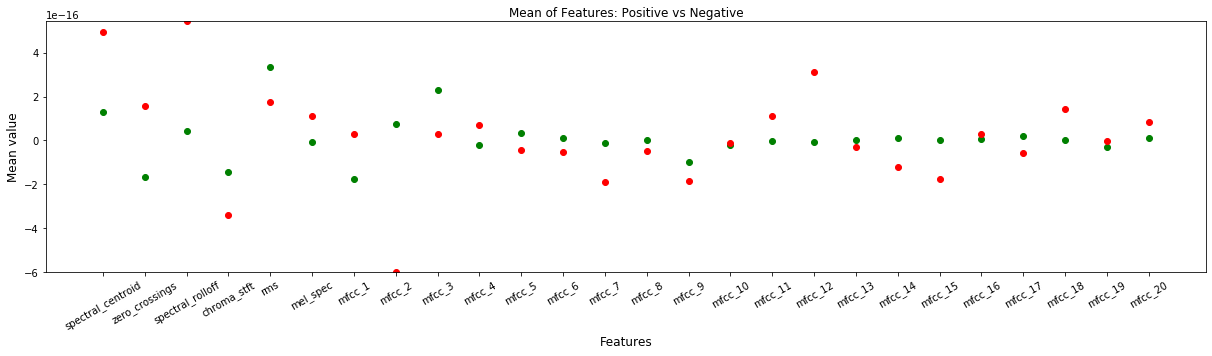

In [183]:
# plot

min_a=np.min(np_pos_scaled_mean)
max_a=np.max(np_pos_scaled_mean)
min_b=np.min(np_neg_scaled_mean)
max_b=np.max(np_neg_scaled_mean)
min_t=np.minimum(min_b,min_a )
max_t=np.maximum(max_b,max_a )


plt.figure(figsize=(50, 5))
ax = plt.subplot(132)
ax.set_xticklabels(features, rotation=30)
axes = plt.gca()
axes.set_ylim([min_t, max_t])

plt.scatter(features, np_pos_scaled_mean,c='green')
plt.scatter(features, np_neg_scaled_mean,c='red')
plt.suptitle('Mean of Features: Positive vs Negative')
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Mean value', fontsize=12)
plt.tight_layout()
plt.savefig('features_mean-Pos_vs_Neg')
plt.show()

show differences in Images from Positives & Negatives (Image aspect in Image vs Math)

In [187]:
# quick check of audio- how it sounds
pos_wav_path = "train\positive\scream\\1_scream_female_room.wav"
#ipd.Audio(filename=pos_wav_path,rate=22050)
neg_wav_path = "train\\negative\\Far_miss\\0d20191008163744pnull_sec_start_0.wav"
ipd.Audio(filename=neg_wav_path,rate=22050)



In [ ]:
wav_paths = [pos_wav_path, neg_wav_path ]

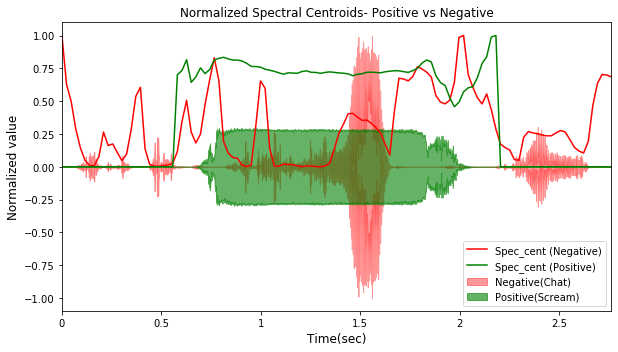

In [316]:
# spectral centroids in red
pos_wav_data, pos_sampling_rate = librosa.load(pos_wav_path, duration=5, sr=22050)
neg_wav_data, neg_sampling_rate = librosa.load(neg_wav_path, duration=5, sr=22050)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

feature_spectralCentroid = librosa.feature.spectral_centroid(y=neg_wav_data, sr=pos_sampling_rate)[0]
# feature_wav_spec_cent.shape  # (1, 120)
# compute time for visualization
frames = range(len(feature_spectralCentroid))
t = librosa.frames_to_time(frames)  # shape (120,)

plt.figure(figsize=(25,5))
ax_2 = plt.subplot(133)
# plt.suptitle('Normalized Spectral Centroids- Positive vs Negative')
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(neg_wav_data, sr=neg_sampling_rate,
                         alpha=0.4,label='Negative(Chat)',color= 'r')
# plt.suptitle('neg')
plt.plot(t, normalize(feature_spectralCentroid), color='r'
        ,label='Spec_cent (Negative)')
#plt.savefig('plots/neg_test' +'_spectral_centroids.jpeg', bbox_inches='tight')

### ### ###
feature_spectralCentroid = librosa.feature.spectral_centroid(y=pos_wav_data, sr=pos_sampling_rate)[0]
# feature_wav_spec_cent.shape  # (1, 120)
# compute time for visualization
frames = range(len(feature_spectralCentroid))
t = librosa.frames_to_time(frames)  # shape (120,)


#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(pos_wav_data, sr=neg_sampling_rate, alpha=0.6,
                         label='Positive(Scream)',color= 'g')



plt.plot(t, normalize(feature_spectralCentroid), color='g'
        ,label='Spec_cent (Positive)')

# ax.set_xlabel('Features', fontsize=12)
ax_2.set_title('Normalized Spectral Centroids- Positive vs Negative')
ax_2.set_ylabel('Normalized value', fontsize=12)
ax_2.set_xlabel('Time(sec)', fontsize=12)

plt.legend(loc='lower right')
plt.tight_layout()

plt.savefig('images/spectral_centroids-Pos_vs_Neg.jpeg', bbox_inches='tight')
plt.show()


Zero crossing rate experiments...

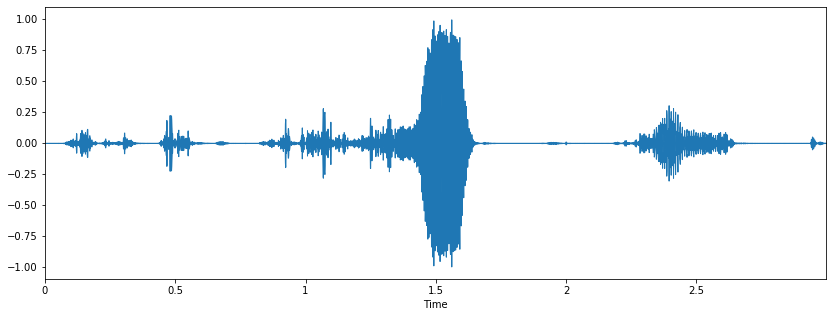

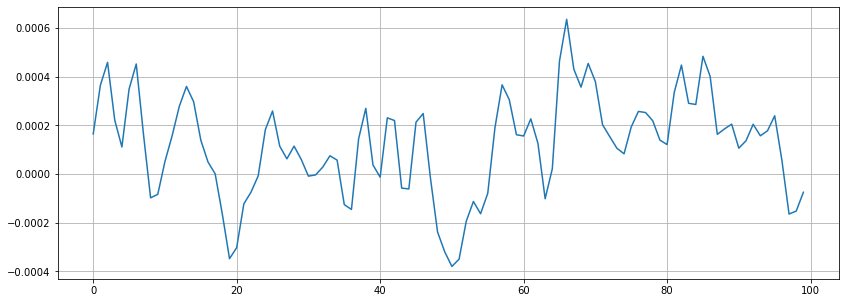

In [221]:
# zero crossings
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(neg_wav_data, sr=neg_sampling_rate)
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(neg_wav_data[n0:n1])
plt.grid()



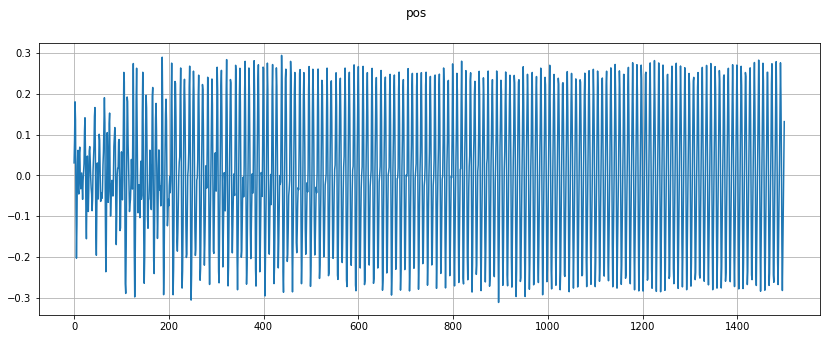

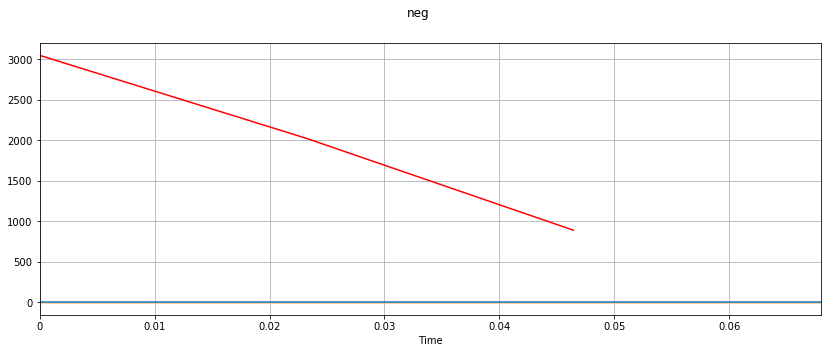

In [270]:
n0 = 17000
n1 = 18500
plt.figure(figsize=(14, 5))
plt.plot(pos_wav_data[n0:n1])
plt.suptitle('pos')
plt.grid()
plt.figure(figsize=(14, 5))
plt.suptitle('neg')
plt.plot(neg_wav_data[n0:n1])
plt.grid()

feature_spectralCentroid = librosa.feature.spectral_centroid(y=neg_wav_data[n0:n1], sr=pos_sampling_rate)[0]
# feature_wav_spec_cent.shape  # (1, 120)
# compute time for visualization
frames = range(len(feature_spectralCentroid))
t = librosa.frames_to_time(frames)  # shape (120,)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(neg_wav_data[n0:n1], sr=neg_sampling_rate, alpha=0.4)
plt.plot(t, feature_spectralCentroid, color='r')

In [266]:
zero_crossings = librosa.zero_crossings(pos_wav_data[n0:n1], pad=False)
print('pos= ',sum(zero_crossings))#16

zero_crossings = librosa.zero_crossings(neg_wav_data[n0:n1], pad=False)
print('neg= ',sum(zero_crossings))#16

pos=  352
neg=  242


In [267]:
ipd.Audio(pos_wav_data[n0:17500],rate=22050)

In [268]:
ipd.Audio(neg_wav_data[n0:17500],rate=22050)

combine pos and neg to 1 image

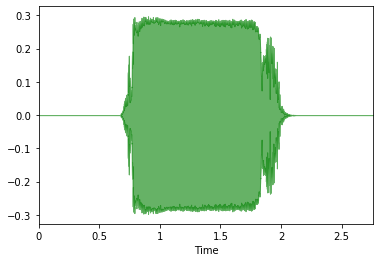

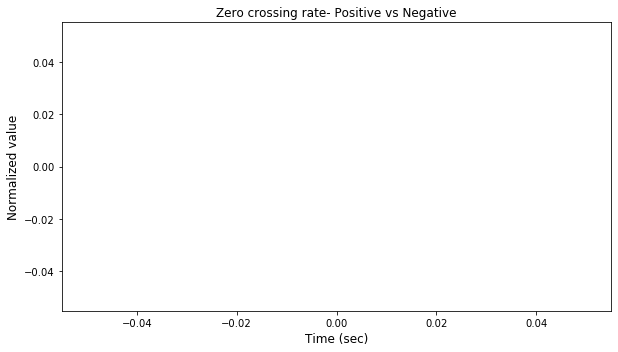

In [321]:
feature_ZCR = librosa.feature.zero_crossing_rate(y=pos_wav_data)
feature_ZCR.shape  # (1, 120)
# compute time for visualization
frames = range(len(feature_ZCR))
t = librosa.frames_to_time(frames)  # shape (120,)

# Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(pos_wav_data, sr=neg_sampling_rate, alpha=0.6,
                         label='Positive(Scream)',color= 'g')

plt.figure(figsize=(25,5))
ax_3 = plt.subplot(133)

plt.plot(t, normalize(feature_ZCR), color='g'
         ,label='Spec_cent (Positive)')

ax_3.set_title('Zero crossing rate- Positive vs Negative')
ax_3.set_ylabel('Normalized value', fontsize=12)
ax_3.set_xlabel('Time (sec)', fontsize=12)

#plt.legend(loc='lower right')
plt.tight_layout()

# plt.savefig('images/spectral_centroids-Pos_vs_Neg.jpeg', bbox_inches='tight')
plt.show()


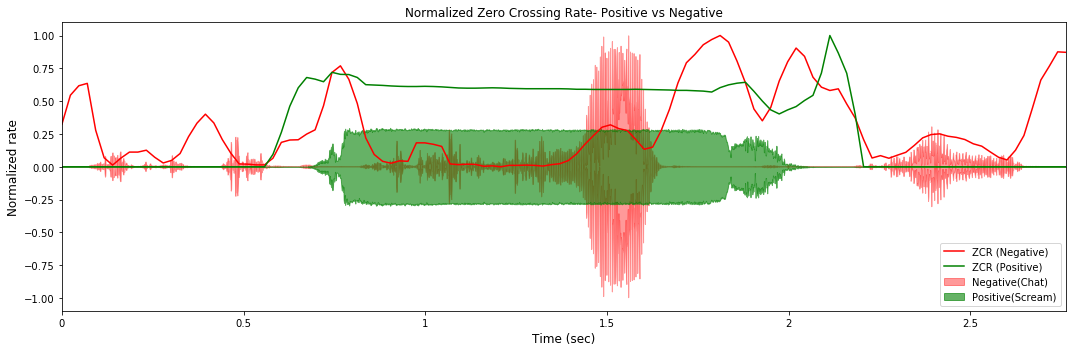

In [341]:
plt.figure(figsize=(15,5))
ax_3 = plt.subplot(111)

feature_ZCR = librosa.feature.zero_crossing_rate(y=neg_wav_data)
frames = range(len(feature_ZCR[0]))
t = librosa.frames_to_time(frames)  # shape (130,)
plt.plot(t, normalize(feature_ZCR[0]), color='r'
        ,label='ZCR (Negative)')
librosa.display.waveplot(neg_wav_data, sr=neg_sampling_rate,
                         alpha=0.4,label='Negative(Chat)',color= 'r')
## now for positive
feature_ZCR = librosa.feature.zero_crossing_rate(y=pos_wav_data)
frames = range(len(feature_ZCR[0]))
t = librosa.frames_to_time(frames)  # shape (130,)
plt.plot(t, normalize(feature_ZCR[0]), color='g'
        ,label='ZCR (Positive)')
librosa.display.waveplot(pos_wav_data, sr=pos_sampling_rate,
                         alpha=0.6,label='Positive(Scream)',color= 'g')


# finishing visualization
ax_3.set_title('Normalized Zero Crossing Rate- Positive vs Negative')
ax_3.set_ylabel('Normalized rate', fontsize=12)
ax_3.set_xlabel('Time (sec)', fontsize=12)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('images/ZCR-Pos_vs_Neg.jpeg', bbox_inches='tight')
plt.show()


spectral rolloff

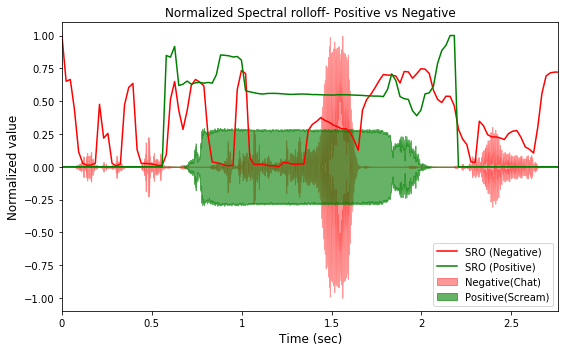

In [347]:
plt.figure(figsize=(15,5))
ax_4 = plt.subplot(122)

feature_SRO = librosa.feature.spectral_rolloff(y=neg_wav_data)
frames = range(len(feature_SRO[0]))
t = librosa.frames_to_time(frames)  # shape (130,)
plt.plot(t, normalize(feature_SRO[0]), color='r'
        ,label='SRO (Negative)')
librosa.display.waveplot(neg_wav_data, sr=neg_sampling_rate,
                         alpha=0.4,label='Negative(Chat)',color= 'r')
## now for positive
feature_SRO = librosa.feature.spectral_rolloff(y=pos_wav_data)
frames = range(len(feature_SRO[0]))
t = librosa.frames_to_time(frames)  # shape (130,)
plt.plot(t, normalize(feature_SRO[0]), color='g'
        ,label='SRO (Positive)')
librosa.display.waveplot(pos_wav_data, sr=pos_sampling_rate,
                         alpha=0.6,label='Positive(Scream)',color= 'g')


# finishing visualization
ax_4.set_title('Normalized Spectral rolloff- Positive vs Negative')
ax_4.set_ylabel('Normalized value', fontsize=12)
ax_4.set_xlabel('Time (sec)', fontsize=12)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('images/SRO-Pos_vs_Neg.jpeg', bbox_inches='tight')
plt.show()

chromagram

TypeError: 'module' object is not callable

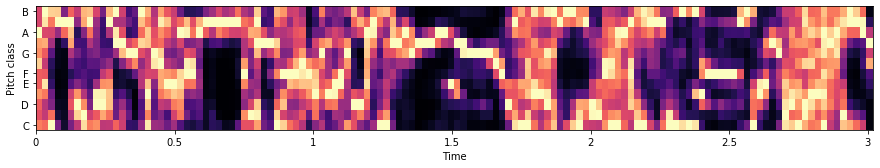

In [368]:
plt.figure(figsize=(15,5))
plt.subplot(211)

feature_chromagram = librosa.feature.chroma_stft(y=neg_wav_data, sr=neg_sampling_rate)
librosa.display.specshow(feature_chromagram, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.ylabel('Scales')
# finishing visualization
plt.subplot(122)
feature_chromagram_true = librosa.feature.chroma_stft(y=pos_wav_data, sr=pos_sampling_rate)
librosa.display.specshow(feature_chromagram_true, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.ylabel('Scales')
plt.tight_layout()

# ax_5[0].set_title('Cromagram scales intensity- Negative')
# ax_5[0].set_ylabel(, fontsize=12)
# ax_5[0].set_xlabel('Time (sec)', fontsize=12)

# # finishing visualization

# ax_5[1].set_title('Cromagram scales intensity- Positive')
# ax_5[1].set_ylabel('Scales', fontsize=12)
# ax_5[1].set_xlabel('Time (sec)', fontsize=12)
# plt.colorbar()

# plt.tight_layout()
# # plt.savefig('images/Cromagram-Pos_vs_Neg.jpeg', bbox_inches='tight')
# plt.show()

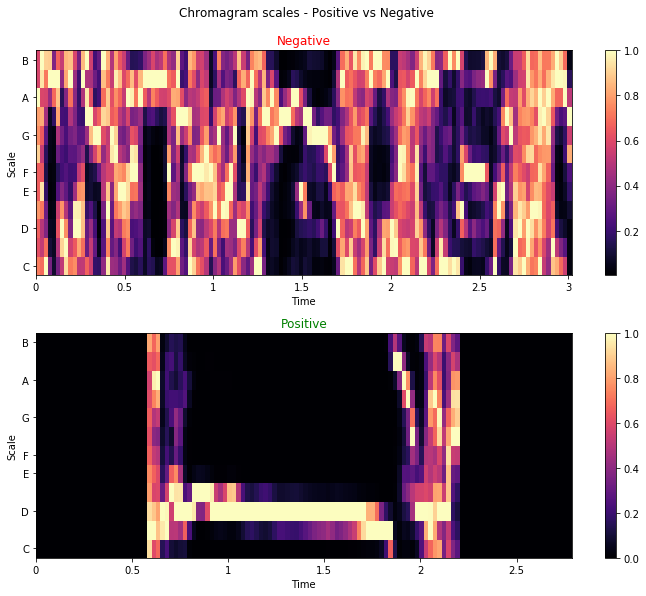

In [429]:
plt.figure(figsize=(10, 8))
ax_6 = plt.subplot(2, 1, 1)

ax_6.set_title('Negative', color='r')
librosa.display.specshow(feature_chromagram, x_axis='time', y_axis='chroma')
plt.colorbar()
# plt.suptitle('a')
plt.ylabel('Scale')
ax_7 = plt.subplot(2, 1, 2,)
librosa.display.specshow(feature_chromagram_true, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.ylabel('Scale')
ax_7.set_title('Positive', color='g')
plt.suptitle('Chromagram scales - Positive vs Negative',y=1.03,x=0.43)
plt.tight_layout()
plt.savefig('images/Cromagram-Pos_vs_Neg.jpeg', bbox_inches='tight')
plt.show()


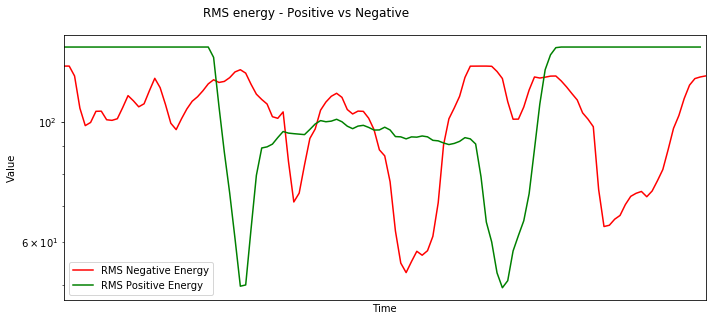

In [430]:
#  rms (and mfccs) 
n_mfcc = 20  # resolution amount
mfccs = librosa.feature.mfcc(y=neg_wav_data, sr=neg_sampling_rate, n_mfcc=n_mfcc)
S, phase = librosa.magphase(mfccs)
rms = librosa.feature.rms(S=S)

mfccs = librosa.feature.mfcc(y=pos_wav_data, sr=pos_sampling_rate, n_mfcc=n_mfcc)
S, phase = librosa.magphase(mfccs)
rms_pos = librosa.feature.rms(S=S)


plt.figure(figsize=(10, 8))
ax_6 = plt.subplot(2, 1, 1)
plt.semilogy(rms.T, label='RMS Negative Energy',color='r')
plt.xticks([])
plt.xlim([0, rms.shape[-1]])

plt.semilogy(rms_pos.T, label='RMS Positive Energy', color='g')
plt.xticks([])
plt.xlim([0, rms_pos.shape[-1]])



plt.legend()
# ax_7 = plt.subplot(2, 1, 2,)
# librosa.display.specshow(feature_chromagram_true, x_axis='time', y_axis='chroma')
# plt.colorbar()
plt.ylabel('Value')
plt.xlabel('Time')
# ax_7.set_title('Positive', color='g')
plt.suptitle('RMS energy - Positive vs Negative',y=1.03,x=0.43)
plt.tight_layout()
plt.savefig('images/RMS_energy-Pos_vs_Neg.jpeg', bbox_inches='tight')
plt.show()

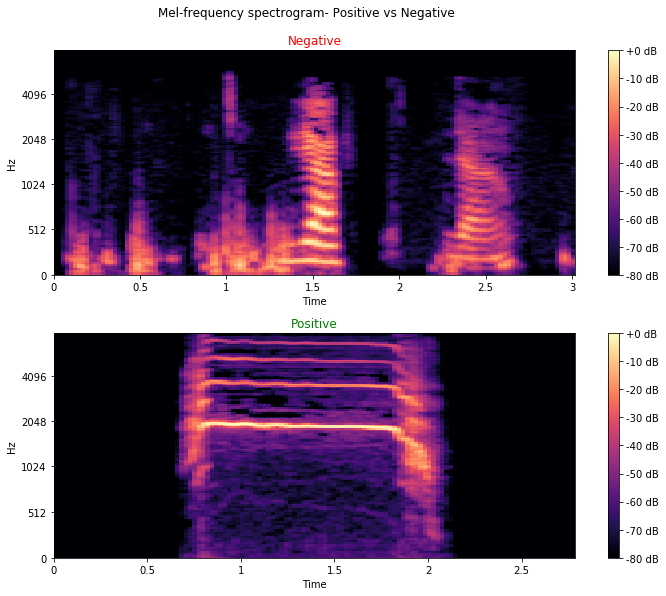

In [435]:
plt.figure(figsize=(10, 8))
ax_6 = plt.subplot(2, 1, 1)
ax_6.set_title('Negative', color='r')
S = librosa.feature.melspectrogram(y=neg_wav_data, sr=neg_sampling_rate)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=neg_sampling_rate,
                          fmax=8000)
plt.colorbar(format='%+2.0f dB')

ax_7 = plt.subplot(2, 1, 2,)
S = librosa.feature.melspectrogram(y=pos_wav_data, sr=pos_sampling_rate)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=pos_sampling_rate,
                          fmax=8000)
plt.colorbar(format='%+2.0f dB')
ax_7.set_title('Positive', color='g')
plt.suptitle('Mel-frequency spectrogram- Positive vs Negative',y=1.03,x=0.43)
plt.tight_layout()
plt.savefig('images/Mel_spec-Pos_vs_Neg.jpeg', bbox_inches='tight')
plt.show()


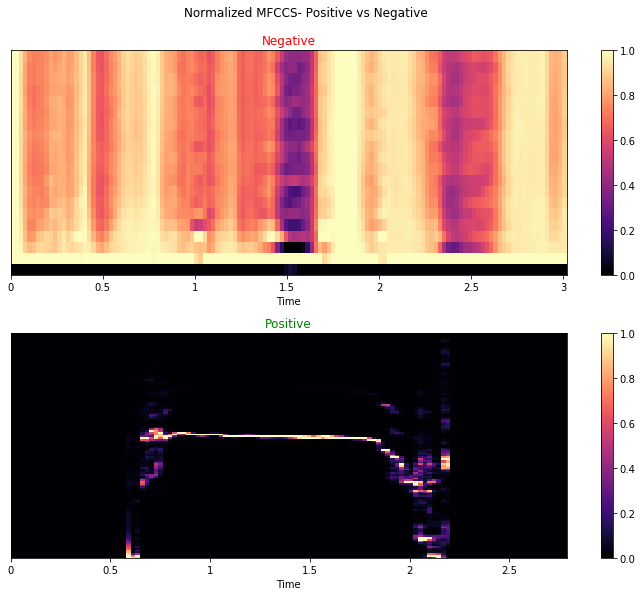

In [440]:
plt.figure(figsize=(10, 8))
ax_6 = plt.subplot(2, 1, 1)
ax_6.set_title('Negative', color='r')
mfccs = librosa.feature.mfcc(y=neg_wav_data, sr=neg_sampling_rate)
librosa.display.specshow(normalize(mfccs), x_axis='time', sr=neg_sampling_rate)
plt.colorbar()

ax_7 = plt.subplot(2, 1, 2,)
mfccs_pos = librosa.feature.melspectrogram(y=pos_wav_data, sr=pos_sampling_rate)
librosa.display.specshow(normalize(mfccs_pos), x_axis='time', sr=pos_sampling_rate)
plt.colorbar()
ax_7.set_title('Positive', color='g')
plt.suptitle('Normalized MFCCS- Positive vs Negative',y=1.03,x=0.43)
plt.tight_layout()
plt.savefig('images/Normalized_MFCCS-Pos_vs_Neg.jpeg', bbox_inches='tight')
plt.show()


my code snippet experiments

In [22]:
import IPython.display as ipd
wav_name = "train\positive\scream\\1_scream_female_room.wav"
print(wav_name)

train\positive\scream\1_scream_female_room.wav


In [23]:
ipd.Audio(filename=wav_name,rate=22050)

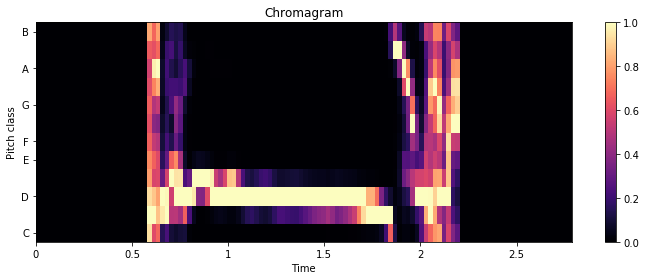

In [29]:
import librosa
import librosa.display
wav_data, sampling_rate = librosa.load(wav_name, duration=5, sr=22050)
chroma_stft = librosa.feature.chroma_stft(y=wav_data, sr=sampling_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.savefig('chroma')
plt.show()


In [34]:
chroma_stft.shape

(12, 120)